<a href="https://colab.research.google.com/github/kallepalomaki/MovieLens-recommender/blob/main/Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader

In [6]:
np.std(np.random.randn(1,100)*0.01)

0.009950231744386764

In [2]:
!wget -nc https://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip ml-25m.zip

--2022-11-27 21:01:16--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  14.0MB/s    in 20s     

2022-11-27 21:01:38 (12.4 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


In [3]:
df=pd.read_csv('ml-25m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [4]:
df.userId=pd.Categorical(df.userId)
df.userId=df.userId.cat.codes
user_ids=df.userId.values

In [5]:
df.movieId=pd.Categorical(df.movieId)
df.movieId=df.movieId.cat.codes
movie_ids=df.movieId.values

In [6]:
ratings=df.rating.values
# keep rmse scaling but center
rating_mean=ratings.mean()
ratings-=rating_mean
np.mean(ratings)


-3.427872505066647e-17

In [7]:
num_users=len(set(user_ids))
num_movies=len(set(movie_ids))

In [8]:
# Embedding dim
embedding_dim=10

In [15]:
class Model(nn.Module):
  def __init__(self, num_users, num_movies, embedding_dim, num_hidden=512):
    super(Model, self).__init__()
    self.num_users=num_users
    self.num_movies=num_movies
    self.embedding_dim=embedding_dim

    self.gen_user_embedding=nn.Embedding(self.num_users, self.embedding_dim)
    self.gen_movie_embedding=nn.Embedding(self.num_movies, self.embedding_dim)
    nn.init.normal_(self.gen_user_embedding.weight, 0.0 , 0.01)
    nn.init.normal_(self.gen_movie_embedding.weight, 0.0 , 0.01)
    self.linear_stack = nn.Sequential(
            nn.Linear(2* self.embedding_dim, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1),
        )
    
  def forward(self, user_ids, movie_ids):
    user_embedding=self.gen_user_embedding(user_ids)
    movie_embedding=self.gen_movie_embedding(movie_ids)
    embeddings=torch.cat((user_embedding, movie_embedding),1)
    logits=self.linear_stack(embeddings)
    
    return logits

In [16]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
model=Model(num_users=num_users, num_movies=num_movies, num_hidden=512, embedding_dim=embedding_dim)
model.to(device)

Model(
  (gen_user_embedding): Embedding(162541, 10)
  (gen_movie_embedding): Embedding(59047, 10)
  (linear_stack): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [18]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters())

In [19]:
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
user_ids=torch.from_numpy(user_ids).long()
movie_ids=torch.from_numpy(movie_ids).long()
ratings=torch.from_numpy(ratings).float()

In [20]:
print(user_ids.shape, movie_ids.shape, ratings.shape)


torch.Size([25000095]) torch.Size([25000095]) torch.Size([25000095])


In [21]:
train_len=int(0.8*len(ratings))

In [22]:
train_data=TensorDataset(user_ids[:train_len], movie_ids[:train_len], ratings[:train_len])
test_data=TensorDataset(user_ids[train_len:], movie_ids[train_len:], ratings[train_len:])

In [23]:
batch_size=512
train_loader=DataLoader(dataset=train_data,
                        batch_size=batch_size,
                        shuffle=True)
test_loader=DataLoader(dataset=test_data,
                        batch_size=batch_size,
                        shuffle=False)

In [24]:
def train(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)

  for it in range(epochs):
    t0=datetime.now()
    train_loss=[]
    for users, movies, targets in train_loader:
      users, movies, targets=users.to(device), movies.to(device), targets.to(device)
      model.zero_grad()
      pred_ratings=model(users, movies)
      #print(pred_ratings.shape, targets.shape)
      loss=criterion(pred_ratings, targets.reshape(-1,1))
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_losses[it]=np.mean(train_loss)
    test_loss=[]  
    for users, movies, targets in test_loader:
      users, movies, targets=users.to(device), movies.to(device), targets.to(device)
      model.zero_grad()
      pred_ratings=model(users, movies)
      loss=criterion(pred_ratings, targets.reshape(-1,1))
      test_loss.append(loss.item())
    test_losses[it]=np.mean(test_loss)
    print("iteration: ", it, "/", epochs, " train loss: ", train_losses[it], "test loss: ", test_losses[it])
  
  return train_losses, test_losses 



In [25]:
train_losses, test_losses=train(model, criterion, optimizer, train_loader, test_loader, 25 )

iteration:  0 / 25  train loss:  0.7259126937125705 test loss:  0.6826610095141341
iteration:  1 / 25  train loss:  0.6511603831127944 test loss:  0.6472043442922661
iteration:  2 / 25  train loss:  0.6155260495563606 test loss:  0.6342818051509478
iteration:  3 / 25  train loss:  0.5947637924258312 test loss:  0.6265320959526717
iteration:  4 / 25  train loss:  0.5810392467605993 test loss:  0.6219978274080613
iteration:  5 / 25  train loss:  0.5715355795823133 test loss:  0.6204027089029215
iteration:  6 / 25  train loss:  0.5646246158675085 test loss:  0.6191173012282745
iteration:  7 / 25  train loss:  0.5594803025483066 test loss:  0.6169634102621504
iteration:  8 / 25  train loss:  0.5553292264904908 test loss:  0.6165917692841405
iteration:  9 / 25  train loss:  0.5519349530357933 test loss:  0.6177916905106322
iteration:  10 / 25  train loss:  0.5491185014711695 test loss:  0.6176295234010573
iteration:  11 / 25  train loss:  0.5467299921316744 test loss:  0.617340577569087
ite

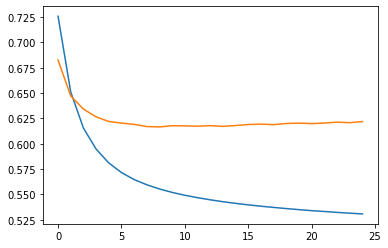

In [26]:
plt.plot(train_losses)
plt.plot(test_losses)

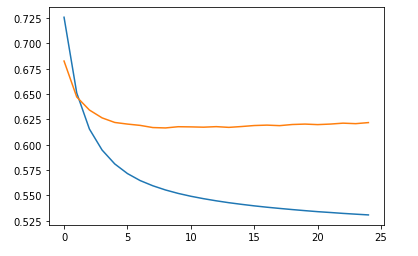

Kuvakaappaus 25 epochs ja ao. malli. Punainen käyrä eli testidatan virhe alkaa kasvaa joten vaikuttaa siltä, että tällä kofiguraatiolla on ylioppimista.

 Model(
  (gen_user_embedding): Embedding(162541, 10)
  (gen_movie_embedding): Embedding(59047, 10)
  (linear_stack): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
) 